https://www.tensorflow.org/tutorials/keras/basic_classification

https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py


In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(tr_im,tr_lab),(tt_im,tt_lab) = fashion_mnist.load_data()

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
tr_im.shape

(60000, 28, 28)

In [ ]:
tr_lab

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

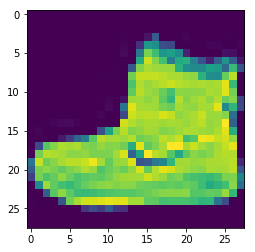

In [ ]:
plt.imshow(tr_im[0,:,:])

In [ ]:
npar = 100 #number of standard normal deviates to feed to generator input

In [ ]:
tr_im.max()

255

In [ ]:
tr_im = tr_im / tr_im.max()
tr_im = tr_im.reshape(tr_im.shape[0],784)

In [ ]:
tt_im = tt_im / tt_im.max()
tt_im = tt_im.reshape(tt_im.shape[0],784)

In [ ]:
#opt = tf.train.AdamOptimizer(learning_rate=0.0005,beta1=0.5)
opt = keras.optimizers.Adam(lr=0.0005,beta_1=0.5)

In [ ]:
generator = keras.Sequential()
generator.add(keras.layers.Dense(256, input_dim=npar, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
generator.add(keras.layers.LeakyReLU(0.2))
generator.add(keras.layers.Dense(512))
generator.add(keras.layers.LeakyReLU(0.2))
generator.add(keras.layers.Dense(1024))
generator.add(keras.layers.LeakyReLU(0.2))
generator.add(keras.layers.Dense(784, activation="sigmoid"))
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               803600    
Total para

In [ ]:
discriminator = keras.Sequential()
discriminator.add(keras.layers.Reshape((28,28,1),input_shape=(784,)))
discriminator.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation=tf.nn.relu))
discriminator.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation=tf.nn.relu))
discriminator.add(keras.layers.MaxPool2D(pool_size=(2,2)))
discriminator.add(keras.layers.Dropout(0.25))
discriminator.add(keras.layers.Flatten())
discriminator.add(keras.layers.Dense(128,activation=tf.nn.relu))
discriminator.add(keras.layers.Dropout(0.5))
discriminator.add(keras.layers.Dense(1,activation="sigmoid"))
# discriminator.summary()
# discriminator = keras.Sequential()
# discriminator.add(keras.layers.Dense(1024, input_dim=784, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
# discriminator.add(keras.layers.LeakyReLU(0.2))
# discriminator.add(keras.layers.Dropout(0.3))
# discriminator.add(keras.layers.Dense(512))
# discriminator.add(keras.layers.LeakyReLU(0.2))
# discriminator.add(keras.layers.Dropout(0.3))
# discriminator.add(keras.layers.Dense(256))
# discriminator.add(keras.layers.LeakyReLU(0.2))
# discriminator.add(keras.layers.Dropout(0.3))
# discriminator.add(keras.layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=opt)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1605760   
__________

In [ ]:
discriminator.trainable = False
gi = keras.layers.Input(shape=(npar,))
x = generator(gi)
go = discriminator(x)
gan = keras.Model(inputs=gi,outputs=go)
gan.compile(loss="binary_crossentropy",optimizer=opt)

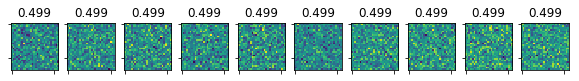

In [ ]:

def plot_gen():
    fig, axes = plt.subplots(nrows=1,ncols=10,figsize = (10,10))
    plot_noise = np.random.randn(10,npar) 
    vecs = generator.predict(plot_noise)#.reshape(10,28,28)
    isreal = discriminator.predict(vecs)
    #print(isreal.shape)
    for ax,vec,real in zip(axes.flatten(),vecs.reshape(10,28,28),isreal.flatten()):
        ax.imshow(vec)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title("{0:1.3G}".format(real))
plot_gen()
#generator.save("test.h5")
o_d = "gen_models"
if os.path.exists(o_d):
    shutil.rmtree(o_d)
os.mkdir(o_d)

468


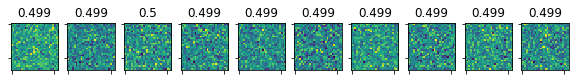

In [ ]:
batch_size = 128
batch_count = int(tr_im.shape[0] / batch_size)
print(batch_count)
plot_gen()
plt.show()
for e in range(1,400):
    for _ in range(batch_count):
        noise = np.random.randn(batch_size,npar)
        tr_im_batch = tr_im[np.random.randint(0,tr_im.shape[0],size=batch_size)]
        gen_im = generator.predict(noise)
        #print(gen_im.shape,tr_im_batch.shape)
        tr_im_batch = np.concatenate([tr_im_batch,gen_im])
        #noisy labels...
        tr_im_lab = np.zeros(tr_im_batch.shape[0])
        tr_im_lab[:batch_size] = np.random.uniform(0.9,1.0,size=batch_size)
        tr_im_lab[batch_size:] = np.random.uniform(0.0,0.1,size=batch_size)
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(tr_im_batch,tr_im_lab)
        noise = np.random.randn(batch_size,npar)
        tr_img_lab = np.ones(batch_size)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise,tr_img_lab)
        print(gloss,dloss,end="\r")
    if e % 1 == 0:
        #print(e,dloss,gloss)
        plot_gen()
        plt.show()
        generator.save(os.path.join(o_d,"gen_{0}.h5").format(e))
        
    